# DATA2001 Assignment 1: Greater + Inner Sydney Livability Analysis

## PRE-PROCESSING

In [1]:
#import data science and analytics libraries + postgres extension
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import inspect
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os

In [2]:
#initiate connection to the database through helper functions used during tutorials
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [3]:
db, conn = pgconnect(credentials)

Connected successfully.


In [4]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


# TASK 01

## Neighbourhoods.csv

### Cleaning Neighbourhoods Dataset

In [5]:
neighbourhoods = pd.read_csv("Neighbourhoods.csv")

#cleaning
del neighbourhoods['Unnamed: 0']
neighbourhoods.fillna(method = 'ffill', inplace = True)
neighbourhoods["population"] = neighbourhoods["population"].replace(",","", regex = True)
neighbourhoods["number_of_dwellings"] = neighbourhoods["number_of_dwellings"].replace(",","", regex = True)
neighbourhoods["population"] = neighbourhoods["population"].astype(str).astype(np.int64)
neighbourhoods["number_of_dwellings"] = neighbourhoods["number_of_dwellings"].astype(str).astype(np.int64)
neighbourhoods.rename(columns = {'0-4' : 'zero_to_four', '5-9' : 'five_to_nine', '10-14' : 'ten_to_fourteen', '15-19' : 'fifteen_to_nineteen'}, inplace = True)
neighbourhoods

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,zero_to_four,five_to_nine,ten_to_fourteen,fifteen_to_nineteen
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,467,583,604,560
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907.0,42621.0,1682.0,586,696,661,692
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102.0,42105.0,1182.0,220,254,304,320
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666.0,43481.0,1595.0,695,778,916,838
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126.0,45972.0,1382.0,1200,1079,963,977
...,...,...,...,...,...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931,3281,673.0,73164.0,1080.0,432,590,577,527
318,106011113,Singleton Region,4067.2349,4919,2055,698.0,87984.0,1000.0,310,394,353,323
319,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154.0,58084.0,1260.0,813,855,828,962
320,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400.0,81120.0,1512.0,443,500,470,451


### Initializing Database table for Neighbourhoods

We initially set most of these as integers, however ran into issues regarding the liveability scores becoming zero, which further led to DivisionByZero errors when calculating the z-scores for the different metrics. Thus for functionality sake we set most of these measurements to floats instead so that we can at least get a bearing on the measurements.

We've also created a column for the total amount of young people so that we can use this when measuring school performance in the area.

In both the Neighbourhoods and the BusinessStat data, we filled empty values as dropping these rows with null values did not make sense. Dropping these rows with null values would just leave us incomplete data and we cannot get an accurate picture of Greater/Inner city Sydney by dropping these values.

In [6]:
conn.execute("""
DROP TABLE IF EXISTS neighbourhoods cascade;;
CREATE TABLE neighbourhoods(
   area_id INTEGER PRIMARY KEY,
   area_name VARCHAR(50),
   land_area FLOAT,
   population FLOAT,
   number_of_dwellings FLOAT,
   number_of_businesses FLOAT,
   median_annual_household_income FLOAT,
   avg_monthly_rent FLOAT,
   zero_to_four FLOAT,
   five_to_nine FLOAT,
   ten_to_fourteen FLOAT,
   fifteen_to_nineteen FLOAT,
   young_people FLOAT
);""")

neighbourhoods.to_sql("neighbourhoods", con = conn, if_exists='append', index = False)
neighbourhood = query(conn, "select * from neighbourhoods limit 10")
neighbourhood

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,zero_to_four,five_to_nine,ten_to_fourteen,fifteen_to_nineteen,young_people
0,102011028,Avoca Beach - Copacabana,643.8,7590.0,2325.0,738.0,46996.0,1906.0,467.0,583.0,604.0,560.0,None
1,102011029,Box Head - MacMasters Beach,3208.6,10986.0,3847.0,907.0,42621.0,1682.0,586.0,696.0,661.0,692.0,None
2,102011030,Calga - Kulnura,76795.1,4841.0,1575.0,1102.0,42105.0,1182.0,220.0,254.0,304.0,320.0,None
3,102011031,Erina - Green Point,3379.3,14237.0,4450.0,1666.0,43481.0,1595.0,695.0,778.0,916.0,838.0,None
4,102011032,Gosford - Springfield,1691.2,19385.0,6373.0,2126.0,45972.0,1382.0,1200.0,1079.0,963.0,977.0,None
5,102011033,Kariong,830.6,6540.0,1824.0,352.0,47896.0,1649.0,472.0,502.0,497.0,591.0,None
6,102011034,Kincumber - Picketts Valley,1208.9,7428.0,1946.0,479.0,41642.0,1397.0,404.0,458.0,448.0,416.0,None
7,102011035,Narara,770.2,6853.0,2006.0,292.0,46660.0,1512.0,463.0,470.0,448.0,459.0,None
8,102011036,Niagara Park - Lisarow,1673.2,8173.0,2345.0,477.0,45762.0,1495.0,525.0,605.0,617.0,606.0,None
9,102011037,Point Clare - Koolewong,678.7,6281.0,2220.0,312.0,45966.0,1572.0,371.0,412.0,373.0,343.0,None


## BusinessStats.csv

### Cleaning BusinessStats Dataset

In [7]:
business_stats = pd.read_csv('BusinessStats.csv')
business_stats.fillna(method = 'ffill', inplace = True)
print(business_stats.dtypes)

area_id                               int64
area_name                            object
number_of_businesses                  int64
accommodation_and_food_services       int64
retail_trade                          int64
agriculture_forestry_and_fishing      int64
health_care_and_social_assistance     int64
public_administration_and_safety      int64
transport_postal_and_warehousing      int64
dtype: object


### Initializing table for BusinessStats.csv

In [8]:
conn.execute("""
DROP TABLE IF EXISTS business_stats;
CREATE TABLE business_stats(
   area_id INTEGER PRIMARY KEY,
   area_name VARCHAR(50),
   number_of_businesses FLOAT,
   accommodation_and_food_services FLOAT,
   retail_trade FLOAT,
   agriculture_forestry_and_fishing FLOAT,
   health_care_and_social_assistance FLOAT,
   public_administration_and_safety FLOAT,
   transport_postal_and_warehousing FLOAT
);""")
business_stats.to_sql("business_stats", con = conn, if_exists='append', index = False)
query(conn, "select * from business_stats limit 10")

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629.0,26.0,27.0,280.0,11.0,0.0,35.0
1,101021008,Karabar,326.0,7.0,10.0,8.0,11.0,0.0,43.0
2,101021009,Queanbeyan,724.0,52.0,47.0,11.0,56.0,3.0,77.0
3,101021010,Queanbeyan - East,580.0,16.0,23.0,4.0,12.0,0.0,57.0
4,101021011,Queanbeyan Region,1642.0,39.0,63.0,292.0,34.0,7.0,81.0
5,101021012,Queanbeyan West - Jerrabomberra,885.0,14.0,48.0,14.0,29.0,3.0,59.0
6,101031013,Bombala,419.0,18.0,14.0,250.0,9.0,0.0,14.0
7,101031014,Cooma,714.0,55.0,47.0,110.0,36.0,0.0,49.0
8,101031015,Cooma Region,478.0,11.0,15.0,258.0,5.0,0.0,26.0
9,101031016,Jindabyne - Berridale,1032.0,144.0,59.0,161.0,43.0,3.0,27.0


## Catchments Dataset

### Cleaning and Integrating Catchmenets Dataset

In [9]:
catchments_primary = gpd.read_file("catchments_primary.shp")
catchments_primary

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((147.94621 -34.55863, 147.95292 -34.5..."
1662,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((148.12885 -35.60082, 148.23155 -35.6..."
1663,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((146.86148 -35.87511, 146.87402 -35.8..."
1664,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((145.18403 -29.65805, 145.18434 -29.6..."


In [10]:
catchments_secondary = gpd.read_file("catchments_secondary.shp")
catchments_secondary

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8246,HIGH_COED,Heathcote HS,None,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((151.03281 -34.02521, 151.03267 -34.0..."
4,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,8213,HIGH_BOYS,Birrong BHS,20211221,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((151.05364 -33.85076, 151.06142 -33.8..."
431,8857,HIGH_GIRLS,GRC Penshurst Girls,20220110,N,N,N,N,N,N,N,Y,Y,Y,Y,N,N,None,"POLYGON ((151.07573 -33.95089, 151.07921 -33.9..."
432,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
433,1115,CENTRAL_HIGH,Balranald CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


In [11]:
catchments_future = gpd.read_file("catchments_future.shp")
catchments_future

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,2133,PRIMARY,Harbord PS,20200720,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,"POLYGON ((151.29769 -33.76832, 151.29731 -33.7..."
1,4450,PRIMARY,Berinba PS,20220110,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,"POLYGON ((149.10301 -34.82127, 149.10167 -34.8..."
2,4683,PRIMARY,Murrumbateman PS,20220110,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,"POLYGON ((149.10557 -34.89523, 149.11035 -34.8..."
3,4021,PRIMARY,Manly Vale PS,20200805,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,"POLYGON ((151.27162 -33.76913, 151.27116 -33.7..."
4,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
5,2469,PRIMARY,Manly WPS,20200805,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,"POLYGON ((151.28453 -33.78790, 151.28559 -33.7..."
6,8463,HIGH_COED,Sylvania HS,20210217,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,"POLYGON ((151.14827 -33.99111, 151.14859 -33.9..."
7,8404,HIGH_COED,Endeavour Sp HS,20210217,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,"POLYGON ((151.12719 -34.01025, 151.12706 -34.0..."
8,3827,PRIMARY,Narraweena PS,20200720,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,"POLYGON ((151.26725 -33.74242, 151.26789 -33.7..."
9,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [12]:
#join all catchments together
catchments = pd.concat([catchments_primary, catchments_secondary, catchments_future], ignore_index = True)
catchments

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,4680,PRIMARY,Googong PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,NaN,"POLYGON ((149.26653 -35.49838, 149.26703 -35.5..."
2141,2540,PRIMARY,Michelago PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,NaN,"POLYGON ((149.14237 -35.56872, 149.16075 -35.5..."
2142,8922,HIGH_COED,Jerrabomberra HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,NaN,"POLYGON ((149.19808 -35.38147, 149.19852 -35.3..."
2143,8919,HIGH_COED,Bungendore HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,NaN,"POLYGON ((149.24085 -34.91439, 149.24367 -34.9..."


## Break Ins Dataset 

In [13]:
break_ins = gpd.read_file("BreakEnterDwelling_JanToDec2021.shp")
break_ins

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geometry
0,1,8.0,Low Density,1,0.012138,0.000006,"POLYGON ((149.91078 -37.06636, 149.91080 -37.0..."
1,2,8.0,Low Density,1,0.019106,0.000015,"POLYGON ((149.90601 -37.05837, 149.90602 -37.0..."
2,3,8.0,Low Density,1,0.006068,0.000002,"POLYGON ((148.94250 -37.04209, 148.94253 -37.0..."
3,4,8.0,Low Density,1,0.011006,0.000006,"POLYGON ((149.19583 -36.91833, 149.19584 -36.9..."
4,5,8.0,Low Density,1,0.008073,0.000003,"POLYGON ((149.84836 -36.68459, 149.84838 -36.6..."
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,"POLYGON ((153.27961 -28.55388, 153.27964 -28.5..."
2590,2591,10.0,High Density,3,0.028327,0.000029,"POLYGON ((150.35939 -28.60530, 150.35941 -28.6..."
2591,2592,10.0,High Density,3,0.006654,0.000002,"POLYGON ((153.56825 -28.38307, 153.56828 -28.3..."
2592,2593,10.0,High Density,3,0.047098,0.000044,"POLYGON ((153.53917 -28.18858, 153.53920 -28.1..."


## SA2 Dataset

In [14]:
sa_two = gpd.read_file("SA2_2016_AUST.shp")
sa_two.drop(sa_two[(sa_two['geometry'] == None)].index, inplace = True)
sa_two

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,"POLYGON ((148.80406 -35.37620, 148.80416 -35.3..."
2304,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,"POLYGON ((105.67392 -10.41567, 105.67398 -10.4..."
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."


# SRID Transformations and Data Cleaning


In [15]:
#function borrowed from Week 9 Tutorial to transform Polygon data
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

School years and dates are not important for us, we just want to know what schools belong in which area, so we have removed them.

In [16]:
srid = 4326
catchments_og = catchments.copy()
catchments['geom'] = catchments['geometry'].apply(lambda x: create_wkt_element(geom = x, srid = srid))
catchments = catchments.drop(columns = ['geometry', 'PRIORITY', 'ADD_DATE'])
#drop school years
school_years =  ['KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12']
catchments = catchments.drop(columns = school_years)
catchments.rename(columns = {'USE_ID':'use_id', 'CATCH_TYPE':'catch_type', 'USE_DESC':'use_desc'}, inplace = True)
catchments

,use_id,catch_type,use_desc,geom
0,2838,PRIMARY,Parklea PS,MULTIPOLYGON (((150.93563850416 -33.7161211047...
1,3943,PRIMARY,Gordon WPS,MULTIPOLYGON (((151.140850430121 -33.744626792...
2,2404,PRIMARY,Lindfield EPS,MULTIPOLYGON (((151.1833640465581 -33.74748398...
3,4393,PRIMARY,Carlingford WPS,MULTIPOLYGON (((151.0451821055135 -33.77303212...
4,4615,PRIMARY,Caddies Ck PS,MULTIPOLYGON (((150.9256732797658 -33.72960300...
...,...,...,...,...
2140,4680,PRIMARY,Googong PS,MULTIPOLYGON (((149.266534585277 -35.498376844...
2141,2540,PRIMARY,Michelago PS,MULTIPOLYGON (((149.1423730577154 -35.56871609...
2142,8922,HIGH_COED,Jerrabomberra HS,MULTIPOLYGON (((149.1980792584528 -35.38147320...
2143,8919,HIGH_COED,Bungendore HS,MULTIPOLYGON (((149.2408471104619 -34.91439387...


In [17]:
break_ins_og = break_ins.copy()
break_ins['geom'] = break_ins['geometry'].apply(lambda x: create_wkt_element(geom = x, srid = srid))
break_ins = break_ins.drop(columns = 'geometry')
break_ins.rename(columns = {'OBJECTID':'objectid', 'Contour':'contour', 'Density':'density', 'ORIG_FID':'orig_fid', 'Shape_Leng':'shape_leng', 'Shape_Area':'shape_area'}, inplace = True)
break_ins

,objectid,contour,density,orig_fid,shape_leng,shape_area,geom
0,1,8.0,Low Density,1,0.012138,0.000006,MULTIPOLYGON (((149.9107801470001 -37.06636313...
1,2,8.0,Low Density,1,0.019106,0.000015,MULTIPOLYGON (((149.9060088220001 -37.05836717...
2,3,8.0,Low Density,1,0.006068,0.000002,MULTIPOLYGON (((148.9424993900001 -37.04208530...
3,4,8.0,Low Density,1,0.011006,0.000006,MULTIPOLYGON (((149.1958326340001 -36.91833255...
4,5,8.0,Low Density,1,0.008073,0.000003,MULTIPOLYGON (((149.8483600650001 -36.68458912...
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,MULTIPOLYGON (((153.2796105350001 -28.55387845...
2590,2591,10.0,High Density,3,0.028327,0.000029,MULTIPOLYGON (((150.3593920080001 -28.60530123...
2591,2592,10.0,High Density,3,0.006654,0.000002,MULTIPOLYGON (((153.568248161 -28.383068159999...
2592,2593,10.0,High Density,3,0.047098,0.000044,MULTIPOLYGON (((153.5391676050001 -28.18857974...


In [18]:
sa_two_og = sa_two.copy()
sa_two['geom'] = sa_two['geometry'].apply(lambda x: create_wkt_element(geom = x, srid = srid))
sa_two = sa_two.drop(columns = 'geometry')
sa_two.rename(columns = {'SA2_MAIN16':'sa2_main16','SA2_5DIG16':'sa2_5dig16','SA2_NAME16':'sa2_name16','SA3_CODE16':'sa3_code16',
              'SA3_NAME16':'sa3_name16','SA4_CODE16':'sa4_code16','SA4_NAME16':'sa4_name16','GCC_CODE16':'gcc_code16','GCC_NAME16':'gcc_name16','STE_CODE16':'ste_code16','STE_NAME16':'ste_name16','AREASQKM16':'areasqkm16'}, inplace = True)
#Filter so that we are only covering areas in the Greater Sydney Region
sa_two = sa_two[sa_two['gcc_code16'] == '1GSYD']
sa_two

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom
27,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,MULTIPOLYGON (((151.3539836770001 -33.49854010...
29,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,MULTIPOLYGON (((151.204595054 -33.532982995999...
30,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,MULTIPOLYGON (((151.3679483220001 -33.43822416...
31,102011032,11032,Gosford - Springfield,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,16.9124,MULTIPOLYGON (((151.310060818 -33.426989095999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,128021537,11537,Royal National Park,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,139.3336,MULTIPOLYGON (((151.071650994 -34.057945007999...
572,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,7.7547,MULTIPOLYGON (((151.05049439 -34.0200584319999...
573,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9538,MULTIPOLYGON (((150.9956780320001 -34.05362100...
574,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,3.8436,MULTIPOLYGON (((151.0395427830001 -34.04175791...


In [19]:
conn.execute("""
DROP TABLE IF EXISTS catchments;
CREATE TABLE catchments (
    use_id INTEGER,
    catch_type VARCHAR(20),
    use_desc VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON, 4326)
);""")

conn.execute("""
DROP TABLE IF EXISTS break_ins;
CREATE TABLE break_ins (
    objectid INTEGER PRIMARY KEY,
    contour INTEGER,
    density VARCHAR(20),
    orig_fid INTEGER,
    shape_leng FLOAT(6),
    shape_area FLOAT(6),
    geom GEOMETRY(MULTIPOLYGON, 4326)
);""")

conn.execute("""
DROP TABLE IF EXISTS sa_two;
CREATE TABLE sa_two (
    sa2_main16 INTEGER PRIMARY KEY,
    sa2_5dig16 INTEGER,
    sa2_name16 VARCHAR(50),
    sa3_code16 INTEGER,
    sa3_name16 VARCHAR(50),
    sa4_code16 INTEGER,
    sa4_name16 VARCHAR(50),
    gcc_code16 VARCHAR(5),
    gcc_name16 VARCHAR(50),
    ste_code16 INTEGER,
    ste_name16 VARCHAR(50),
    areasqkm16 FLOAT(4),
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);""")

In [20]:
catchments.to_sql("catchments", con = conn, if_exists='append', index = False, dtype = {'geom': Geometry('MULTIPOLYGON', srid)})
#differentiate the geom names from each other to make sense of where it belongs
query(conn, "ALTER TABLE catchments RENAME COLUMN geom TO geom_catchments; SELECT * FROM catchments ")

,use_id,catch_type,use_desc,geom_catchments
0,2838,PRIMARY,Parklea PS,0106000020E61000000100000001030000000100000078...
1,3943,PRIMARY,Gordon WPS,0106000020E6100000010000000103000000010000006F...
2,2404,PRIMARY,Lindfield EPS,0106000020E610000001000000010300000001000000BE...
3,1498,PRIMARY,Brisbania PS,0106000020E6100000010000000103000000010000001F...
4,4393,PRIMARY,Carlingford WPS,0106000020E61000000100000001030000000100000065...
...,...,...,...,...
2140,4680,PRIMARY,Googong PS,0106000020E61000000100000001030000000100000072...
2141,2540,PRIMARY,Michelago PS,0106000020E610000001000000010300000001000000BF...
2142,8922,HIGH_COED,Jerrabomberra HS,0106000020E61000000100000001030000000100000020...
2143,8919,HIGH_COED,Bungendore HS,0106000020E610000001000000010300000001000000D7...


In [21]:
break_ins.to_sql("break_ins", con = conn, if_exists='append', index = False, dtype = {'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "ALTER TABLE break_ins RENAME COLUMN geom TO geom_break_ins; SELECT * FROM break_ins")

,objectid,contour,density,orig_fid,shape_leng,shape_area,geom_break_ins
0,1,8,Low Density,1,0.012138,0.000006,0106000020E61000000100000001030000000100000015...
1,2,8,Low Density,1,0.019106,0.000015,0106000020E6100000010000000103000000010000001D...
2,3,8,Low Density,1,0.006068,0.000002,0106000020E61000000100000001030000000100000007...
3,4,8,Low Density,1,0.011006,0.000006,0106000020E6100000010000000103000000010000000E...
4,5,8,Low Density,1,0.008073,0.000003,0106000020E6100000010000000103000000010000000F...
...,...,...,...,...,...,...,...
2589,2590,10,High Density,3,0.015358,0.000011,0106000020E61000000100000001030000000100000016...
2590,2591,10,High Density,3,0.028327,0.000029,0106000020E61000000100000001030000000100000028...
2591,2592,10,High Density,3,0.006654,0.000002,0106000020E61000000100000001030000000100000009...
2592,2593,10,High Density,3,0.047098,0.000044,0106000020E6100000010000000103000000010000004D...


In [22]:
sa_two.to_sql("sa_two", con = conn, if_exists='append', index = False, dtype = {'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "ALTER TABLE sa_two RENAME COLUMN geom TO geom_satwo; SELECT * FROM sa_two")

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom_satwo
0,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,0106000020E6100000010000000103000000010000005E...
1,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,0106000020E61000000100000001030000000100000000...
2,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,0106000020E61000000200000001030000000100000085...
3,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,0106000020E61000000100000001030000000100000041...
4,102011032,11032,Gosford - Springfield,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,16.9124,0106000020E6100000010000000103000000010000007F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,128021537,11537,Royal National Park,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,139.3336,0106000020E61000000100000001030000000100000047...
308,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,7.7547,0106000020E61000000100000001030000000100000089...
309,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9538,0106000020E6100000010000000103000000010000008E...
310,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,3.8436,0106000020E610000001000000010300000001000000A1...


Since there are two different observations for the number of businesses from the neighbourhoods dataset and the business_stats dataset, we've decided to only use the observation from the business_stats dataset since it's not clear what the neighbourhoods dataset defines as a business. The business_stat data set on the other hand, gives us a clear and detailed count for what types of businesses they have included in their count.

# TASK 02


In [23]:
#add together the amount of young people
conn.execute("UPDATE neighbourhoods SET young_people = (zero_to_four + five_to_nine + ten_to_fourteen + fifteen_to_nineteen)")
query(conn, "SELECT * FROM neighbourhoods;")

conn.execute("""ALTER TABLE neighbourhoods
RENAME COLUMN area_id TO area_id_n;""")


## Normalising Z-Scores for Each Performance Measure


### Accomodation

In [24]:
conn.execute("""
DROP TABLE IF EXISTS accomodation;
CREATE TABLE accomodation AS
SELECT DISTINCT N.area_id_n, N.area_name, (B.accommodation_and_food_services/(N.population)/1000) AS "accomodation_measure"
FROM neighbourhoods N JOIN business_stats B ON (B.area_id = N.area_id_n);
""")

In [25]:
conn.execute("ALTER TABLE accomodation ADD IF NOT EXISTS accomodation_z_score FLOAT")
conn.execute("""
UPDATE accomodation SET accomodation_z_score = (accomodation_measure - (SELECT AVG(accomodation_measure) FROM accomodation)) / (SELECT STDDEV(accomodation_measure) FROM accomodation)
""")
query(conn, "SELECT * from accomodation")

,area_id_n,area_name,accomodation_measure,accomodation_z_score
0,127021509,Bonnyrigg Heights - Bonnyrigg,0.000002,-0.163015
1,116031317,Mount Druitt - Whalan,0.000002,-0.155641
2,117031336,Surry Hills,0.000015,0.085354
3,117011324,Port Botany Industrial,0.000429,7.861674
4,123021437,Campbelltown - Woodbine,0.000006,-0.093068
...,...,...,...,...
317,127031600,Prestons - Edmondson Park,0.000003,-0.147210
318,123021436,Bradbury - Wedderburn,0.000001,-0.180912
319,115021298,Galston - Laughtondale,0.000002,-0.155573
320,115011554,Castle Hill - East,0.000001,-0.174575


### Retail

In [26]:
conn.execute("""
DROP TABLE IF EXISTS retail;
CREATE TABLE retail AS
SELECT DISTINCT B.area_id, B.area_name, (B.retail_trade/(N.population)/1000) AS "retail_measure"
FROM neighbourhoods N JOIN business_stats B ON (B.area_id = N.area_id_n);
""")

In [27]:
conn.execute("ALTER TABLE retail ADD IF NOT EXISTS retail_z_score FLOAT")
conn.execute("""
UPDATE retail SET retail_z_score = (retail_measure - (SELECT AVG(retail_measure) FROM retail)) / (SELECT STDDEV(retail_measure) FROM retail)
""")
query(conn, "SELECT * from retail")

,area_id,area_name,retail_measure,retail_z_score
0,120031576,Strathfield South,0.000009,-0.116628
1,119031373,Riverwood,0.000004,-0.144409
2,127011596,Hoxton Park - Carnes Hill - Horningsea Park,0.000002,-0.156660
3,127011506,Cobbitty - Leppington,0.000004,-0.148607
4,127031524,Holsworthy - Wattle Grove,0.000003,-0.153571
...,...,...,...,...
317,119031370,Narwee - Beverly Hills,0.000005,-0.142928
318,120031390,Ashfield,0.000005,-0.138477
319,125031487,Yennora Industrial,0.000391,2.197433
320,120031394,Dulwich Hill - Lewisham,0.000004,-0.147142


### Healthcare

In [28]:
conn.execute("""
DROP TABLE IF EXISTS healthcare;
CREATE TABLE healthcare AS
SELECT DISTINCT B.area_id, B.area_name, (B.health_care_and_social_assistance/(N.population)/1000) AS "healthcare_measure"
FROM neighbourhoods N JOIN business_stats B ON (B.area_id = N.area_id_n);
""")

In [29]:
conn.execute("ALTER TABLE healthcare ADD IF NOT EXISTS healthcare_z_score FLOAT")
conn.execute("""
UPDATE healthcare SET healthcare_z_score = (healthcare_measure - (SELECT AVG(healthcare_measure) FROM healthcare)) / (SELECT STDDEV(healthcare_measure) FROM healthcare)
""")
query(conn, "SELECT * from healthcare")

,area_id,area_name,healthcare_measure,healthcare_z_score
0,119011572,Bankstown - South,0.000007,0.017446
1,116011303,Blacktown (East) - Kings Park,0.000009,0.133586
2,120031575,Strathfield,0.000018,0.703227
3,120011384,Concord West - North Strathfield,0.000007,0.036987
4,120011383,Concord - Mortlake - Cabarita,0.000011,0.244678
...,...,...,...,...
317,123031446,Douglas Park - Appin,0.000003,-0.248980
318,119021362,Belmore - Belfield,0.000004,-0.177547
319,102021045,Blue Haven - San Remo,0.000001,-0.349604
320,120031576,Strathfield South,0.000006,-0.043453


### School

In [30]:
conn.execute("""
CREATE OR REPLACE VIEW neighbourhood_satwo AS
SELECT * FROM neighbourhoods N LEFT OUTER JOIN sa_two S on (N.area_id_n = S.sa2_main16);
""")


conn.execute( """
CREATE OR REPLACE VIEW trial AS SELECT SUM(young_people), area_id_n FROM neighbourhood_satwo GROUP BY area_id_n ;
CREATE OR REPLACE VIEW area0 AS SELECT area_id_n FROM trial WHERE sum = 0;
 """)


conn.execute("""
DROP TABLE IF EXISTS school;
CREATE TABLE school AS
SELECT DISTINCT N.area_id_n, N.area_name, (COUNT(C.use_id)/SUM(young_people))/1000 AS "school_measure"
FROM neighbourhood_satwo N LEFT OUTER JOIN catchments C ON ST_Contains(N.geom_satwo, C.geom_catchments)
WHERE N.area_id_n NOT IN (SELECT area_id_n FROM area0)
GROUP BY N.area_id_n, N.area_name
 """)



conn.execute("ALTER TABLE school ADD IF NOT EXISTS school_z_score FLOAT")
conn.execute("""
UPDATE school SET school_z_score = (school_measure - (SELECT AVG(school_measure) FROM school)) / (SELECT STDDEV(school_measure) FROM school)
""")
query(conn, "SELECT * from school where school_measure IS NOT NULL and school_z_score IS NOT NULL")

,area_id_n,area_name,school_measure,school_z_score
0,101051540,Goulburn Region,0.000000e+00,-0.219342
1,102011028,Avoca Beach - Copacabana,0.000000e+00,-0.219342
2,102011029,Box Head - MacMasters Beach,0.000000e+00,-0.219342
3,102011030,Calga - Kulnura,9.107468e-07,13.578877
4,102011031,Erina - Green Point,0.000000e+00,-0.219342
...,...,...,...,...
310,128021537,Royal National Park,0.000000e+00,-0.219342
311,128021538,Sutherland - Kirrawee,2.043318e-07,2.876376
312,128021607,Engadine,0.000000e+00,-0.219342
313,128021608,Loftus - Yarrawarrah,0.000000e+00,-0.219342


### Crime

In [31]:
conn.execute("""
CREATE OR REPLACE VIEW neighbourhood_satwo AS
SELECT * FROM neighbourhoods N LEFT OUTER JOIN sa_two S on (N.area_id_n = S.sa2_main16);
""")

conn.execute("""
DROP TABLE IF EXISTS crime1;
CREATE TABLE crime1 AS
SELECT N.area_id_n, N.area_name, (SUM(ST_Area(B.geom_break_ins, true))/SUM((ST_Area(N.geom_satwo, true)))) AS "crime_measure"
FROM neighbourhood_satwo N LEFT OUTER JOIN break_ins B ON ST_Contains(N.geom_satwo, B.geom_break_ins)
GROUP BY N.area_id_n, N.area_name;
 """)

conn.execute("DROP TABLE IF EXISTS crime; CREATE TABLE crime AS SELECT area_id_n,area_name,coalesce(crime_measure::float,0) AS crime_measure  from crime1 ")



conn.execute("ALTER TABLE crime ADD IF NOT EXISTS crime_z_score FLOAT")
conn.execute("""
UPDATE crime SET crime_z_score = (crime_measure - (SELECT AVG(crime_measure) FROM crime)) / (SELECT STDDEV(crime_measure) FROM crime)
""")

query(conn, "SELECT * from crime;")



,area_id_n,area_name,crime_measure,crime_z_score
0,101051540,Goulburn Region,0.000000,-0.717829
1,102011028,Avoca Beach - Copacabana,0.000000,-0.717829
2,102011029,Box Head - MacMasters Beach,0.001795,-0.627985
3,102011030,Calga - Kulnura,0.000000,-0.717829
4,102011031,Erina - Green Point,0.001458,-0.644887
...,...,...,...,...
317,128021537,Royal National Park,0.000000,-0.717829
318,128021538,Sutherland - Kirrawee,0.098910,4.231753
319,128021607,Engadine,0.026104,0.588451
320,128021608,Loftus - Yarrawarrah,0.000000,-0.717829


### Combining Measures and Calculating Livability Scores

In [32]:
sql = """
DROP TABLE IF EXISTS combination1;
CREATE TABLE combination1 AS
SELECT * FROM accomodation a NATURAL JOIN retail r;


DROP TABLE IF EXISTS combination2;
CREATE TABLE combination2 AS
SELECT * FROM combination1 c NATURAL JOIN healthcare h;


DROP TABLE IF EXISTS combination3;
CREATE TABLE combination3 AS
SELECT * FROM combination2 c NATURAL JOIN school s;

DROP TABLE IF EXISTS combination4;
CREATE TABLE combination4 AS
SELECT * FROM combination3 c NATURAL JOIN crime r;


DROP TABLE IF EXISTS combined_x;
CREATE TABLE combined_x AS
SELECT area_name,
area_id,
accomodation_z_score,
retail_z_score,
healthcare_z_score,
school_z_score,
crime_z_score, 
(accomodation_z_score + retail_z_score + healthcare_z_score + school_z_score - crime_z_score) AS x
FROM combination4;

DROP TABLE IF EXISTS combined_liveability;
CREATE TABLE combined_liveability AS
SELECT area_name,
area_id,
accomodation_z_score,
retail_z_score,
healthcare_z_score,
school_z_score,
crime_z_score, 
x as "total_z_score",
(1/(1+EXP(-x))) AS livability_score
FROM combined_x;

SELECT * FROM combined_liveability order by total_z_score desc ;
"""

query(conn, sql)

,area_name,area_id,accomodation_z_score,retail_z_score,healthcare_z_score,school_z_score,crime_z_score,total_z_score,livability_score
0,Wetherill Park Industrial,127021521,11.659333,11.145398,17.062340,-0.219342,-0.717829,40.365559,1.000000
1,Banksmeadow,117011320,7.861674,7.323088,-0.420359,-0.219342,-0.717829,15.262891,1.000000
2,Calga - Kulnura,102011030,-0.146642,-0.117380,-0.267014,13.578877,-0.717829,13.765670,0.999999
3,Prospect Reservoir,116031318,4.972532,3.006698,-0.420359,-0.219342,-0.717829,8.057358,0.999683
4,Newtown - Camperdown - Darlington,117031332,-0.063292,-0.134982,0.390944,3.522433,-0.717829,4.432932,0.988260
...,...,...,...,...,...,...,...,...,...
310,Bidwill - Hebersham - Emerton,116031313,-0.184164,-0.161239,-0.338713,-0.219342,2.778241,-3.681699,0.024562
311,Hoxton Park - Carnes Hill - Horningsea Park,127011596,-0.162030,-0.156660,-0.257513,-0.219342,3.513582,-4.309126,0.013267
312,Regents Park,125011587,-0.165812,-0.122395,-0.177037,-0.219342,3.876014,-4.560599,0.010348
313,Burwood - Croydon,120031391,-0.064157,-0.109301,0.321311,-0.219342,4.526500,-4.597988,0.009972


We create an index for the easing up of spatial joining for both tables crime and sa_two. This makes sense as the tables are very large. 

In [33]:
conn.execute("""
DROP INDEX IF EXISTS sa_two_index;
CREATE INDEX IF NOT EXISTS sa_two_index ON sa_two USING GIST(geom_satwo)""")

In [34]:
conn.execute("""
DROP INDEX IF EXISTS break_ins_index;
CREATE INDEX IF NOT EXISTS break_ins_index ON break_ins USING GIST(geom_break_ins)""")

## Data Visualisation (Greater Sydney)


### Livability Scores for Regions in Greater Sydney

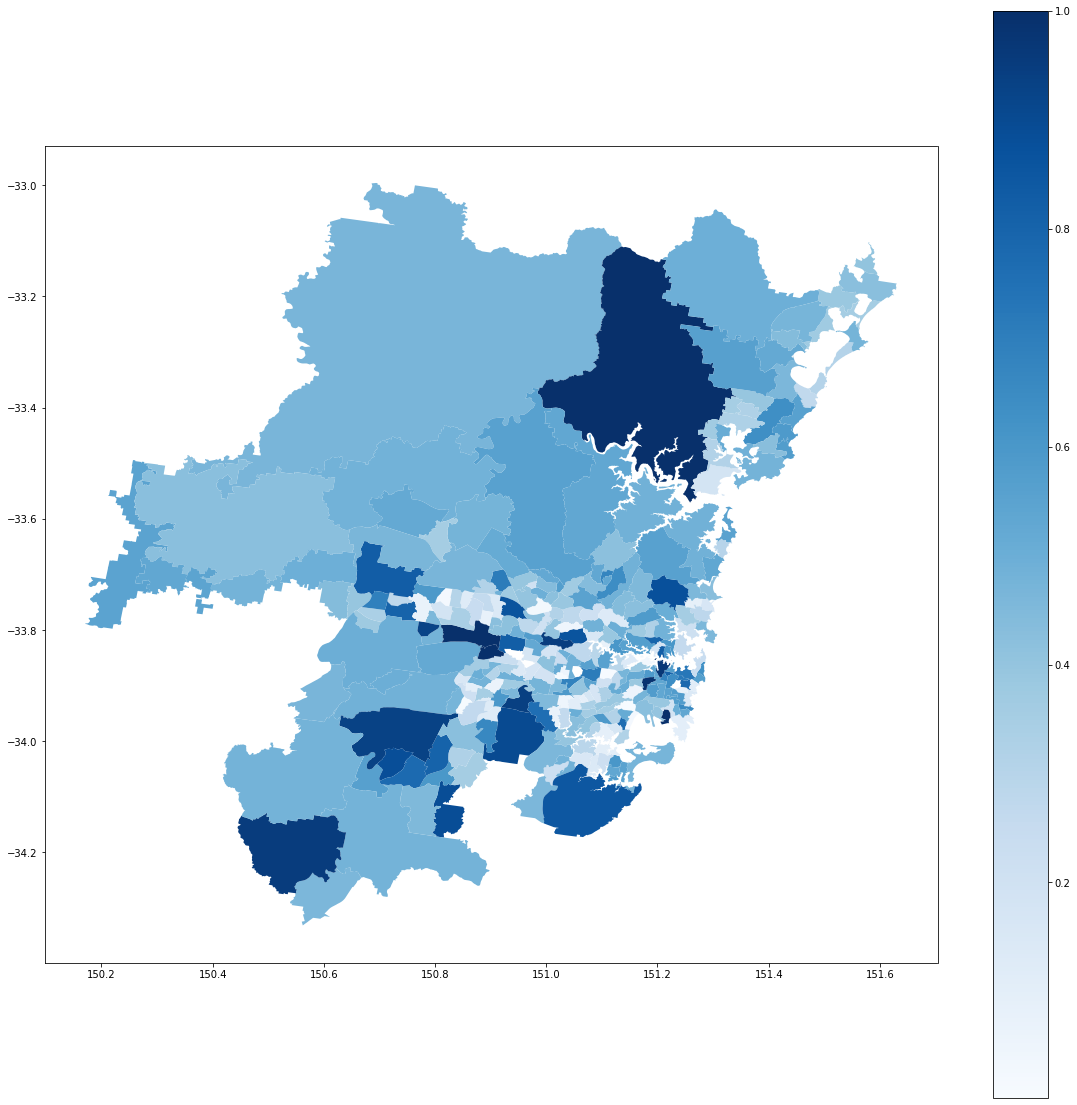

In [35]:
greater_sydney_liveability = gpd.read_postgis("SELECT S.geom_satwo, CL.livability_score FROM sa_two S JOIN combined_liveability CL ON (CL.area_id = S.sa2_main16)", conn, geom_col = 'geom_satwo')
greater_sydney_liveability.plot(column = 'livability_score', cmap = "Blues", legend = True, figsize = (20, 20))

### Total Z-scores for Greater Sydney

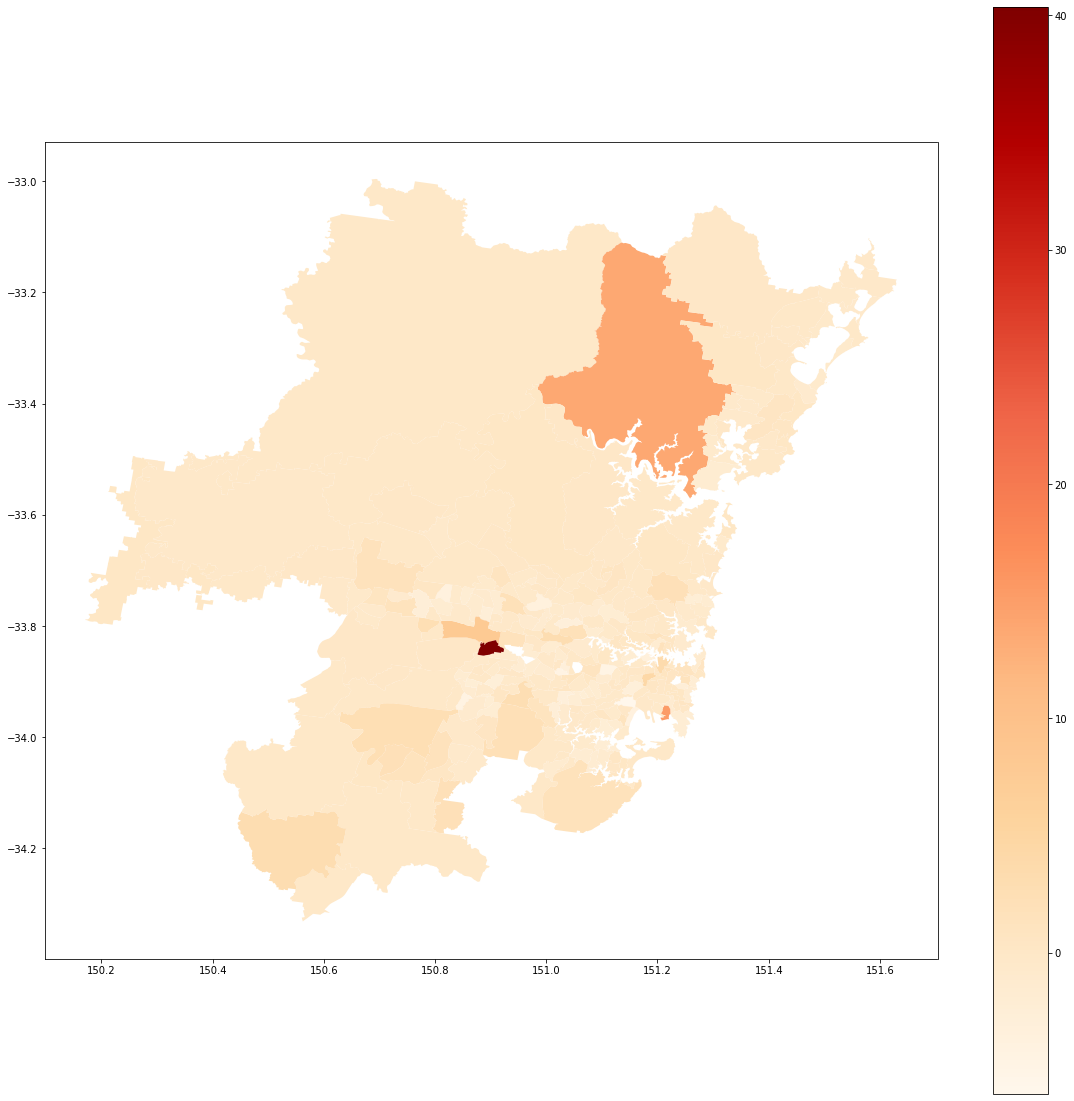

In [36]:
greater_sydney_z_scores = gpd.read_postgis("SELECT S.geom_satwo, CL.total_z_score FROM sa_two S JOIN combined_liveability CL ON (CL.area_id = S.sa2_main16)", conn, geom_col = 'geom_satwo')
greater_sydney_z_scores.plot(column = 'total_z_score', cmap = "OrRd", legend = True, figsize = (20, 20))

In [37]:
sql = """
SELECT area_id, area_name, livability_score from combined_liveability JOIN sa_two ON (area_id = sa2_main16)
ORDER BY livability_score DESC
"""
query(conn, sql)


,area_id,area_name,livability_score
0,127021521,Wetherill Park Industrial,1.000000
1,117011320,Banksmeadow,1.000000
2,102011030,Calga - Kulnura,0.999999
3,116031318,Prospect Reservoir,0.999683
4,117031332,Newtown - Camperdown - Darlington,0.988260
...,...,...,...
300,116031313,Bidwill - Hebersham - Emerton,0.024562
301,127011596,Hoxton Park - Carnes Hill - Horningsea Park,0.013267
302,125011587,Regents Park,0.010348
303,120031391,Burwood - Croydon,0.009972


The high livability scores of Wetherill Park Industrial and Banksmeadow can be explained by their low population provided to us initially in the base csv file which skews the calculations. This causes a false sense that these two areas are the most liveable regions in Greater Sydney. 

A Google search of the two Greater Sydney regions shows that both are industrial and commerical hubs which can explain the reason as to why there are almost no people living in these areas. As such we can "ignore" the scores of 1 for both these suburbs.

The next measurement that has a more realistic population is the Central Coast region of Calga - Kulnura, which has a more reasonable population of 4841. 

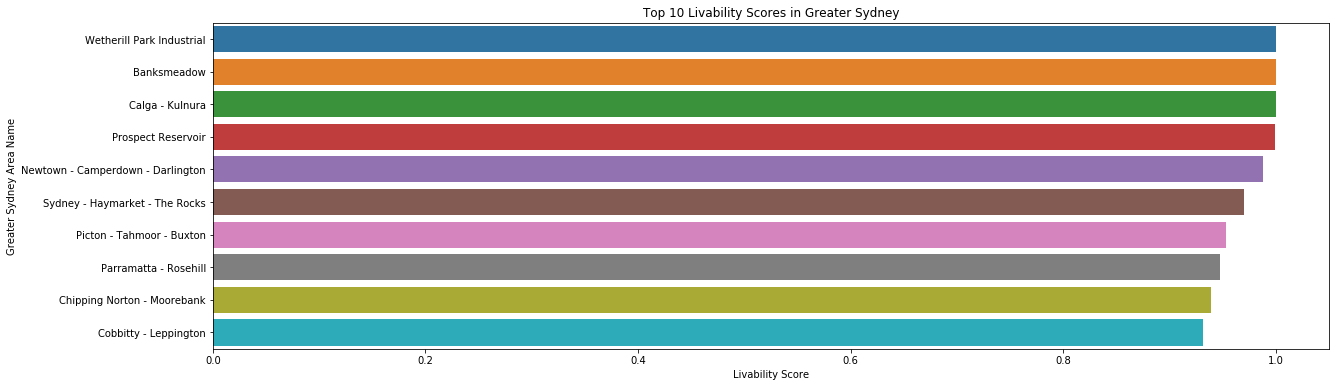

In [38]:
#bar graph that displays top 10 for liveability scores in Greater Sydney
sql = """
SELECT area_id, area_name, livability_score from combined_liveability JOIN sa_two ON (area_id = sa2_main16)
GROUP BY area_id, area_name, livability_score
"""
df = pd.read_sql(sql, conn)

area_names = df.groupby('area_name')['livability_score'].sum().sort_values(ascending = False).index.values
plt.figure(figsize = (20, 6))
sns.barplot(x = 'livability_score', y = 'area_name', data = df, order = area_names[0:10])
plt.xlabel("Livability Score")
plt.ylabel("Greater Sydney Area Name")
plt.title("Top 10 Livability Scores in Greater Sydney")
plt.show()


## Correlation Tests


In [39]:
median_rent_query = """
DROP TABLE IF EXISTS median_rent_table;
CREATE TABLE median_rent_table AS
SELECT CL.area_id, CL.livability_score, PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY N.avg_monthly_rent DESC) AS "median_rent"
FROM combined_liveability CL JOIN neighbourhoods N ON (CL.area_id = N.area_id_n)
GROUP BY CL.area_id, CL.livability_score;
"""
conn.execute(median_rent_query)
rent_query = pd.read_sql_query("SELECT * FROM median_rent_table", conn)
rent_query = rent_query.drop(columns = ["area_id"])
rent_query.corr()

,livability_score,median_rent
livability_score,1.00000,0.07419
median_rent,0.07419,1.00000


In [40]:
median_income_query = """
DROP TABLE IF EXISTS median_income_table;
CREATE TABLE median_income_table AS
SELECT CL.area_id, CL.livability_score, N.median_annual_household_income
FROM combined_liveability CL JOIN neighbourhoods N ON (CL.area_id = N.area_id_n)
GROUP BY CL.area_id, CL.livability_score, N.median_annual_household_income;
"""
conn.execute(median_income_query)
income_query = pd.read_sql_query("SELECT * FROM median_income_table", conn)
income_query = income_query.drop(columns = ["area_id"])
income_query.corr()

,livability_score,median_annual_household_income
livability_score,1.000000,0.161232
median_annual_household_income,0.161232,1.000000


# TASK 03


## Additional Dataset Loading

In [41]:
# load in geojson data
# load in greenhouse data
greenhouse = gpd.read_file("Greenhouse_gas_emissions_profile_by_suburb.geojson")
greenhouse.drop(greenhouse[(greenhouse['geometry'] == None)].index, inplace = True)
greenhouse

,OBJECTID1,Area_suburb,Data_Category,F2005_06,F2006_07,F2007_08,F2008_09,F2009_10,F2010_11,F2011_12,F2012_13,F2013_14,F2014_15,F2015_16,F2016_17,F2017_18,F2018_19,Shape__Area,Shape__Length,geometry
0,1,Newtown + St Peters,Electricity (Disaggregated),68244.718530,68908.392480,54931.528310,54068.546750,54696.062360,55336.992390,53578.532090,53180.756560,51178.372610,46997.936240,45562.361100,40245.232030,39443.476050,37247.541290,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
1,2,Newtown + St Peters,Gas (Disaggregated),4635.031427,4636.506642,4343.603477,4310.464360,4305.069269,4054.575075,4053.222270,4092.708623,4073.800698,4273.516941,4406.080005,4318.561195,4191.225421,4046.531387,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
2,3,Newtown + St Peters,Other Scope 3 (Disaggregated),94.083993,95.014621,94.638781,91.027039,88.262112,85.564922,117.462097,120.220240,122.233699,124.285901,126.276447,129.143203,NaN,NaN,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
3,4,Newtown + St Peters,Transport (Disaggregated),8609.342071,8880.381799,8916.245395,8732.361737,8972.860364,9209.887700,8791.414528,9022.290556,9022.449782,9151.670418,8750.953004,10488.231170,10486.749220,10960.795700,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
4,5,Newtown + St Peters,Waste (Disaggregated),16739.906110,16958.748330,17003.488460,15577.258490,10278.727450,9913.244498,9747.702366,9589.026543,9599.323701,9659.897765,9740.801720,10817.907280,10546.415360,11577.239900,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,170,The Rocks,Gas (Disaggregated),5557.482976,5612.514499,5338.750196,5424.492633,5625.262771,5495.896049,5591.664983,5576.656414,5472.615537,5689.562608,5673.554913,5342.778192,5004.379575,4588.940152,3.091627e+05,3549.527779,"POLYGON ((151.20980 -33.86103, 151.20980 -33.8..."
170,171,The Rocks,Other Scope 3 (Disaggregated),13.801496,14.328316,14.751033,15.350157,15.786199,16.180312,23.417807,24.506947,25.471330,26.467622,27.474428,28.699188,NaN,NaN,3.091627e+05,3549.527779,"POLYGON ((151.20980 -33.86103, 151.20980 -33.8..."
171,172,The Rocks,Transport (Disaggregated),9565.122626,9777.305671,9724.120633,9535.671769,9596.136562,9657.959429,9682.341263,9775.830080,9818.188911,9934.545258,9774.152640,10094.815150,10343.169230,10622.283900,3.091627e+05,3549.527779,"POLYGON ((151.20980 -33.86103, 151.20980 -33.8..."
172,173,The Rocks,Waste (Disaggregated),17797.420930,17964.130990,18139.816430,16347.781450,10678.909390,10709.562900,10789.463930,10834.846400,10930.074020,11033.477280,11167.688200,12309.996080,9301.231959,9839.390406,3.091627e+05,3549.527779,"POLYGON ((151.20980 -33.86103, 151.20980 -33.8..."


In [42]:
# load in recreation centre data
recreation = gpd.read_file("Recreation_centres.geojson")
recreation.drop(recreation[(recreation['geometry'] == None)].index, inplace = True)
recreation

,OBJECTID,Name,Address,Address2,Suburb,Postcode,PhoneNumber,URL,OpeningHours,Lat,Long,geometry
0,1,Redfern Community Centre,29-53 Hugo Street,,Redfern,2016,02 9288 5713,https://www.cityofsydney.nsw.gov.au/community-...,"Monday to Friday 9am to 5pm, Weekends Availabl...",-33.890317,151.198410,POINT (151.19841 -33.89032)
1,2,Pyrmont Community Centre,79a John Street,Corner of John and Mount Streets,Pyrmont,2009,02 9298 3134 or 02 9298 3130,https://www.cityofsydney.nsw.gov.au/community-...,"Monday 9am to 9pm, Tuesday to Thursday 6.30am ...",-33.867972,151.192283,POINT (151.19228 -33.86797)
2,3,Ultimo Community Centre,38-40 William Henry Street,,Ultimo,2007,02 9298 3111,https://www.cityofsydney.nsw.gov.au/community-...,"Monday to Friday 10am to 8pm, Saturday amd Sun...",-33.877822,151.198026,POINT (151.19803 -33.87782)
3,4,King George V Recreation Centre,15 Cumberland Street,,The Rocks,2000,02 9244 3600,https://www.cityofsydney.nsw.gov.au/community-...,"Monday to Friday: 6am–9pm, Saturday and Sunday...",-33.859701,151.206588,POINT (151.20659 -33.85970)
4,5,Juanita Nielsen Community Centre,31 Nicholson Street,Corner of Nicholson and Dowling Streets,Woolloomooloo,2011,02 8374 6323,https://www.cityofsydney.nsw.gov.au/community-...,"Monday and Wednesday: 6am–8pm, Tuesday: 9am–8p...",-33.870276,151.221137,POINT (151.22114 -33.87028)
5,6,Perry Park Recreational Centre,1B Maddox Street,None,Alexandria,2015,02 9288 5651,https://www.cityofsydney.nsw.gov.au/community-...,None,-33.907592,151.195989,POINT (151.19599 -33.90759)


## Additional Dataset Cleaning

We are only interested in the latest emission data, thus we remove outdated emission data and only use the column that has the most recent data available which is the period of 2018-19.

In [43]:
greenhouse_og = greenhouse.copy()
greenhouse['geom'] = greenhouse['geometry'].apply(lambda x: create_wkt_element(geom = x, srid = srid))
greenhouse = greenhouse.drop(columns = ['geometry', 'F2005_06', 'F2006_07', 'F2007_08', 'F2008_09', 'F2009_10', 'F2010_11', 'F2011_12', 'F2012_13', 'F2013_14', 'F2014_15', 'F2015_16', 'F2016_17', 'F2017_18'])
greenhouse.rename(columns = {'OBJECTID1' : 'objectid1', 'Area_suburb' : 'area_suburb', 'Data_Category' : 'data_category', 'F2018_19' : 'f2018_19', 'Shape__Area' : 'shape_area', 'Shape__Length' : 'shape_length'}, inplace = True)
greenhouse.dropna(subset = ['f2018_19'], how = 'all', inplace = True)
greenhouse

,objectid1,area_suburb,data_category,f2018_19,shape_area,shape_length,geom
0,1,Newtown + St Peters,Electricity (Disaggregated),37247.541290,1.427271e+06,8815.394724,MULTIPOLYGON (((151.185707078503 -33.917443990...
1,2,Newtown + St Peters,Gas (Disaggregated),4046.531387,1.427271e+06,8815.394724,MULTIPOLYGON (((151.185707078503 -33.917443990...
3,4,Newtown + St Peters,Transport (Disaggregated),10960.795700,1.427271e+06,8815.394724,MULTIPOLYGON (((151.185707078503 -33.917443990...
4,5,Newtown + St Peters,Waste (Disaggregated),11577.239900,1.427271e+06,8815.394724,MULTIPOLYGON (((151.185707078503 -33.917443990...
6,7,Alexandria,Electricity (Disaggregated),132330.614900,5.129712e+06,12267.960764,MULTIPOLYGON (((151.19913442343 -33.8951673712...
...,...,...,...,...,...,...,...
166,167,Forest Lodge + Annandale,Waste (Disaggregated),4788.847051,7.939478e+05,6817.416670,MULTIPOLYGON (((151.177265964613 -33.872723473...
168,169,The Rocks,Electricity (Disaggregated),76694.135910,3.091627e+05,3549.527779,MULTIPOLYGON (((151.209804657291 -33.861030405...
169,170,The Rocks,Gas (Disaggregated),4588.940152,3.091627e+05,3549.527779,MULTIPOLYGON (((151.209804657291 -33.861030405...
171,172,The Rocks,Transport (Disaggregated),10622.283900,3.091627e+05,3549.527779,MULTIPOLYGON (((151.209804657291 -33.861030405...


We remove the irrelevant columns. We are only interested in which suburb and postcode the recreation centres are interested in, as well as the geometric data associated with it.

In [44]:
recreation_og = recreation.copy()
recreation['geom'] = recreation['geometry'].apply(lambda x: WKTElement(x.wkt, srid = srid))
recreation = recreation.drop(columns = ['geometry', 'Address', 'Address2', 'PhoneNumber', 'URL', 'OpeningHours', 'Lat', 'Long'])
recreation.rename(columns = {'OBJECTID' : 'objectid', 'Name' : 'name', 'Suburb' : 'suburb', 'Postcode' : 'postcode'}, inplace = True)
recreation

,objectid,name,suburb,postcode,geom
0,1,Redfern Community Centre,Redfern,2016,POINT (151.198409720645 -33.8903169365705)
1,2,Pyrmont Community Centre,Pyrmont,2009,POINT (151.192282767682 -33.8679718036201)
2,3,Ultimo Community Centre,Ultimo,2007,POINT (151.19802602897 -33.877821984351)
3,4,King George V Recreation Centre,The Rocks,2000,POINT (151.206588164723 -33.8597010972066)
4,5,Juanita Nielsen Community Centre,Woolloomooloo,2011,POINT (151.221136568611 -33.8702759096478)
5,6,Perry Park Recreational Centre,Alexandria,2015,POINT (151.195988999209 -33.907591591531)


In [45]:
conn.execute("""
DROP TABLE IF EXISTS greenhouse;
CREATE TABLE greenhouse (
    objectid1 INTEGER, 
    area_suburb VARCHAR(50),
    data_category VARCHAR(50),
    f2018_19 FLOAT(6),
    shape_area FLOAT(6),
    shape_length FLOAT(6),
    geom GEOMETRY(MULTIPOLYGON,4326)
);
""")

conn.execute("""
DROP TABLE IF EXISTS recreation;
CREATE TABLE recreation (
    objectid INTEGER PRIMARY KEY,
    name VARCHAR(50),
    suburb VARCHAR(20),
    postcode INTEGER,
    geom GEOMETRY(POINT,4326)
);
""")

In [46]:
greenhouse.to_sql('greenhouse', conn, if_exists = 'append', index = False, dtype = {'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "ALTER TABLE greenhouse RENAME COLUMN geom TO geom_greenhouse; SELECT * FROM greenhouse")

,objectid1,area_suburb,data_category,f2018_19,shape_area,shape_length,geom_greenhouse
0,1,Newtown + St Peters,Electricity (Disaggregated),37247.5430,1427271.00,8815.3950,0106000020E61000000200000001030000000100000052...
1,19,Chippendale,Electricity (Disaggregated),51592.1600,669425.00,3814.8594,0106000020E61000000100000001030000000100000056...
2,20,Chippendale,Gas (Disaggregated),5894.5590,669425.00,3814.8594,0106000020E61000000100000001030000000100000056...
3,2,Newtown + St Peters,Gas (Disaggregated),4046.5315,1427271.00,8815.3950,0106000020E61000000200000001030000000100000052...
4,22,Chippendale,Transport (Disaggregated),9436.6500,669425.00,3814.8594,0106000020E61000000100000001030000000100000056...
...,...,...,...,...,...,...,...
111,170,The Rocks,Gas (Disaggregated),4588.9400,309162.66,3549.5278,0106000020E61000000100000001030000000100000007...
112,172,The Rocks,Transport (Disaggregated),10622.2840,309162.66,3549.5278,0106000020E61000000100000001030000000100000007...
113,173,The Rocks,Waste (Disaggregated),9839.3910,309162.66,3549.5278,0106000020E61000000100000001030000000100000007...
114,155,Potts Point,Waste (Disaggregated),16965.9900,870985.60,6898.1675,0106000020E6100000010000000103000000010000001B...


In [47]:
recreation.to_sql('recreation', conn, if_exists = 'append', index = False, dtype = {'geom': Geometry('POINT', srid)})
query(conn, "ALTER TABLE recreation RENAME COLUMN geom TO geom_recreation; SELECT * FROM recreation")

,objectid,name,suburb,postcode,geom_recreation
0,1,Redfern Community Centre,Redfern,2016,0101000020E61000001FAC575F59E6624096D2C6E7F5F1...
1,2,Pyrmont Community Centre,Pyrmont,2009,0101000020E6100000EAD8302E27E66240013337B319EF...
2,3,Ultimo Community Centre,Ultimo,2007,0101000020E6100000DAC5AE3A56E66240AA3F85785CF0...
3,4,King George V Recreation Centre,The Rocks,2000,0101000020E61000003B67C85E9CE66240396B80AF0AEE...
4,5,Juanita Nielsen Community Centre,Woolloomooloo,2011,0101000020E61000004944FF8C13E762408C37753365EF...
5,6,Perry Park Recreational Centre,Alexandria,2015,0101000020E61000004FBFB88A45E6624008E015F62BF4...


We determine the measure of greenhouse gasses in the region to be the sum of all emissions divided by the area of the region. 

In [48]:
conn.execute("""
CREATE OR REPLACE VIEW neighbourhood_satwo AS
SELECT * FROM neighbourhoods N LEFT OUTER JOIN sa_two S on (N.area_id_n = S.sa2_main16);
""")

conn.execute("""
DROP TABLE IF EXISTS greenhouse_score;
CREATE TABLE greenhouse_score AS
SELECT N.area_id_n, N.area_name, (SUM(G.f2018_19)/SUM((ST_Area(G.geom_greenhouse, true)))) AS "greenhouse_measure"
FROM neighbourhood_satwo N LEFT OUTER JOIN greenhouse G ON ST_Intersects(N.geom_satwo, G.geom_greenhouse)
WHERE N.sa3_name16 = 'Sydney Inner City'
GROUP BY N.area_id_n, N.area_name;
 """)

conn.execute("ALTER TABLE greenhouse_score ADD IF NOT EXISTS greenhouse_z_score FLOAT")
conn.execute("""
UPDATE greenhouse_score SET greenhouse_z_score = (greenhouse_measure - (SELECT AVG(greenhouse_measure) FROM greenhouse_score)) / (SELECT STDDEV(greenhouse_measure) FROM greenhouse_score)
""")

query(conn, "SELECT * from greenhouse_score;")

,area_id_n,area_name,greenhouse_measure,greenhouse_z_score
0,117031329,Darlinghurst,0.087037,0.927603
1,117031330,Erskineville - Alexandria,0.017045,-1.117242
2,117031331,Glebe - Forest Lodge,0.037713,-0.513407
3,117031332,Newtown - Camperdown - Darlington,0.022073,-0.970334
4,117031333,Potts Point - Woolloomooloo,0.101465,1.349123
5,117031334,Pyrmont - Ultimo,0.089753,1.006940
6,117031335,Redfern - Chippendale,0.026376,-0.844621
7,117031336,Surry Hills,0.065253,0.291189
8,117031337,Sydney - Haymarket - The Rocks,0.087691,0.946710
9,117031338,Waterloo - Beaconsfield,0.018458,-1.075962


We determine the recreation measure to be amount of centres per 1000 people.

In [49]:
conn.execute("""
CREATE OR REPLACE VIEW neighbourhood_satwo AS
SELECT * FROM neighbourhoods N LEFT OUTER JOIN sa_two S on (N.area_id_n = S.sa2_main16);
""")

conn.execute("""
DROP TABLE IF EXISTS recreation_score;
CREATE TABLE recreation_score AS
SELECT N.area_id_n, N.area_name, (COUNT(R.name)/SUM(N.population)/1000) AS "recreation_measure"
FROM neighbourhood_satwo N LEFT OUTER JOIN recreation R ON ST_Contains(N.geom_satwo, R.geom_recreation)
WHERE N.sa3_name16 = 'Sydney Inner City'
GROUP BY N.area_id_n, N.area_name
""")

conn.execute("ALTER TABLE recreation_score ADD IF NOT EXISTS recreation_z_score FLOAT")
conn.execute("""
UPDATE recreation_score SET recreation_z_score = (recreation_measure - (SELECT AVG(recreation_measure) FROM recreation_score)) / (SELECT STDDEV(recreation_measure) FROM recreation_score)
""")
query(conn, "SELECT * FROM recreation_score")

,area_id_n,area_name,recreation_measure,recreation_z_score
0,117031329,Darlinghurst,0.000000e+00,-0.918038
1,117031330,Erskineville - Alexandria,5.611043e-08,1.522810
2,117031331,Glebe - Forest Lodge,0.000000e+00,-0.918038
3,117031332,Newtown - Camperdown - Darlington,0.000000e+00,-0.918038
4,117031333,Potts Point - Woolloomooloo,4.200092e-08,0.909035
5,117031334,Pyrmont - Ultimo,4.152307e-08,0.888248
6,117031335,Redfern - Chippendale,3.915733e-08,0.785337
7,117031336,Surry Hills,0.000000e+00,-0.918038
8,117031337,Sydney - Haymarket - The Rocks,3.224766e-08,0.484761
9,117031338,Waterloo - Beaconsfield,0.000000e+00,-0.918038


For inner city Sydney we modify the liveability score with the newly integrated greenhouse and recreation scores. We add the recreation score and subtract the greenhouse score.

In [50]:
sql = """DROP TABLE IF EXISTS combination5;
CREATE TABLE combination5 AS
SELECT * FROM combination4 C NATURAL JOIN greenhouse_score GS;

DROP TABLE IF EXISTS combination6;
CREATE TABLE combination6 AS
SELECT * FROM combination5 C NATURAL JOIN recreation_score GR;

DROP TABLE IF EXISTS combined_final;
CREATE TABLE combined_final AS
SELECT area_name,
area_id,
accomodation_z_score,
retail_z_score,
healthcare_z_score,
school_z_score,
crime_z_score,
greenhouse_z_score,
recreation_z_score,
(accomodation_z_score + retail_z_score + healthcare_z_score + school_z_score + recreation_z_score - crime_z_score - greenhouse_z_score) AS x
FROM combination6;

DROP TABLE IF EXISTS combined_liveability_inner;
CREATE TABLE combined_liveability_inner AS
SELECT area_name,
area_id,
accomodation_z_score,
retail_z_score,
healthcare_z_score,
school_z_score,
crime_z_score, 
greenhouse_z_score,
recreation_z_score,
x as "total_z_score",
(1/(1+EXP(-x))) AS livability_score
FROM combined_final;

SELECT * FROM combined_liveability_inner ORDER BY total_z_score DESC;
"""

query(conn, sql)

,area_name,area_id,accomodation_z_score,retail_z_score,healthcare_z_score,school_z_score,crime_z_score,greenhouse_z_score,recreation_z_score,total_z_score,livability_score
0,Newtown - Camperdown - Darlington,117031332,-0.063292,-0.134982,0.390944,3.522433,-0.717829,-0.970334,-0.918038,4.485227,0.988851
1,Sydney - Haymarket - The Rocks,117031337,0.821200,0.160883,2.007434,-0.219342,-0.717829,0.946710,0.484761,3.026056,0.953737
2,Erskineville - Alexandria,117031330,-0.054319,-0.082500,-0.031597,-0.219342,-0.717829,-1.117242,1.522810,2.970123,0.951206
3,Redfern - Chippendale,117031335,-0.095705,-0.139622,-0.107877,-0.219342,-0.717829,-0.844621,0.785337,1.785242,0.856343
4,Waterloo - Beaconsfield,117031338,-0.086471,-0.118322,-0.169187,-0.219342,-0.717829,-1.075962,-0.918038,0.282431,0.570142
5,Pyrmont - Ultimo,117031334,-0.020597,-0.116856,0.008613,-0.219342,-0.465669,1.006940,0.888248,-0.001205,0.499699
6,Glebe - Forest Lodge,117031331,-0.095622,-0.138626,0.098212,-0.219342,-0.717829,-0.513407,-0.918038,-0.042180,0.489457
7,Potts Point - Woolloomooloo,117031333,-0.043016,-0.135553,-0.009835,-0.219342,-0.717829,1.349123,0.909035,-0.130003,0.467545
8,Darlinghurst,117031329,0.094468,-0.098006,0.974946,-0.219342,-0.717829,0.927603,-0.918038,-0.375746,0.407153
9,Surry Hills,117031336,0.085354,-0.090054,0.285107,-0.219342,-0.717829,0.291189,-0.918038,-0.430333,0.394047


### Livability scores for Inner City Sydney

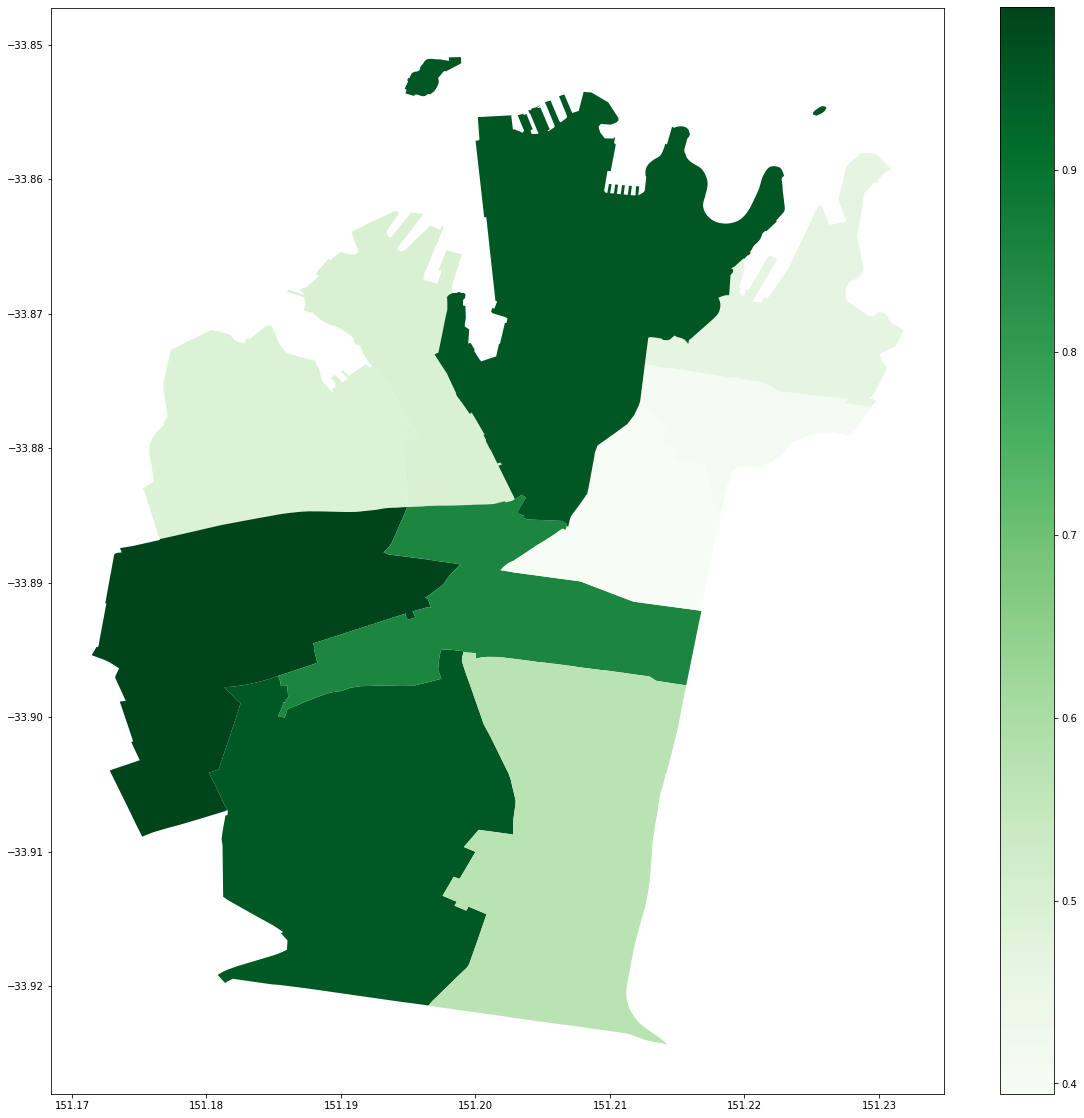

In [51]:
inner_sydney_liveability = gpd.read_postgis("SELECT S.geom_satwo, CLI.livability_score FROM sa_two S JOIN combined_liveability_inner CLI ON (CLI.area_id = S.sa2_main16)", conn, geom_col = 'geom_satwo')
inner_sydney_liveability.plot(column = 'livability_score', cmap = "Greens", legend = True, figsize = (20, 20))

## Greenhouse emissions in Inner City Sydney

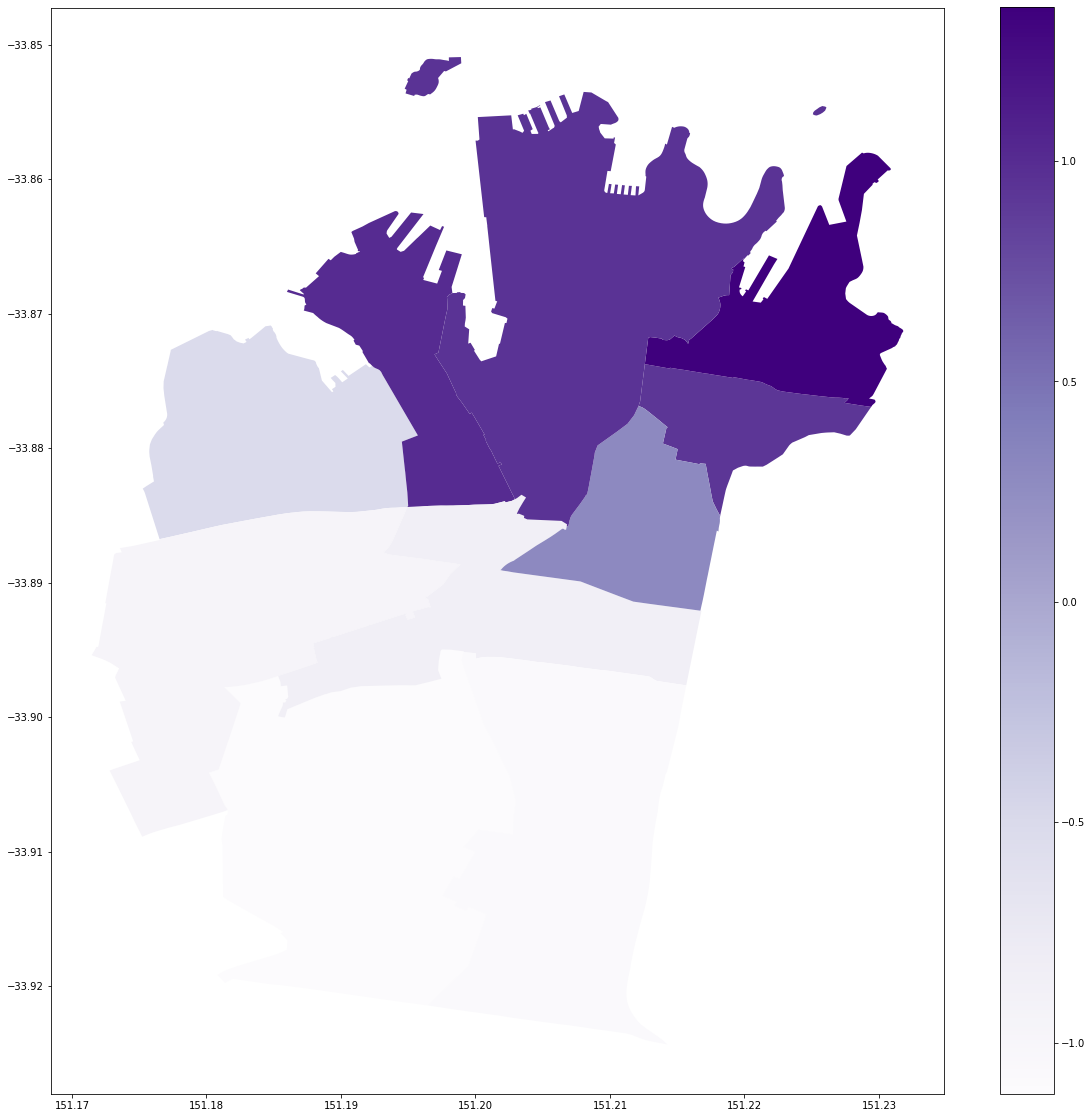

In [52]:
inner_sydney_greenhouse = gpd.read_postgis("SELECT S.geom_satwo, CLI.greenhouse_z_score FROM sa_two S JOIN combined_liveability_inner CLI ON (CLI.area_id = S.sa2_main16)", conn, geom_col = 'geom_satwo')
inner_sydney_greenhouse.plot(column = 'greenhouse_z_score', cmap = "Purples", legend = True, figsize = (20, 20))

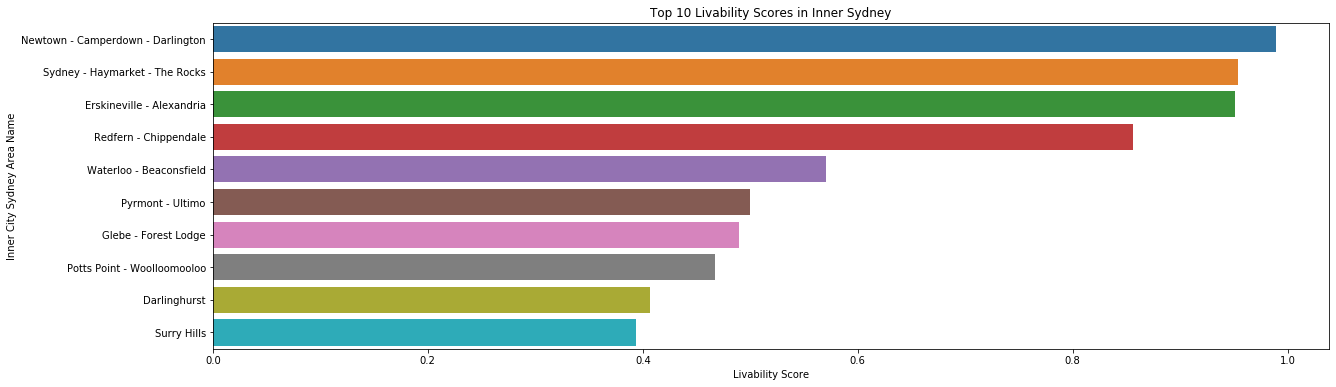

In [53]:
#bar graph attempt, top 10 for liveability score in Inner City Sydney
sql = """
SELECT area_id, area_name, livability_score from combined_liveability_inner JOIN sa_two ON (area_id = sa2_main16)
GROUP BY area_id, area_name, livability_score
"""
df = pd.read_sql(sql, conn)

area_names = df.groupby('area_name')['livability_score'].sum().sort_values(ascending = False).index.values
plt.figure(figsize = (20, 6))
sns.barplot(x = 'livability_score', y = 'area_name', data = df, order = area_names[0:10])
plt.xlabel("Livability Score")
plt.ylabel("Inner City Sydney Area Name")
plt.title("Top 10 Livability Scores in Inner Sydney")
plt.show()

Based on the visualisations above and on the notion that Meriton already has apartment/hotel buildings in the CBD (Sydney - Haymarket - The Rocks), we recommend that they expand to the Newtown - Camperdown - Darlington region based on the livability score rankings above.

In [54]:
conn.close()
db.dispose()